In [1]:
import numpy as np
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # 从 matplotlib.colors 导入 LogNorm

def f(x):
    """
    目标函数 f(x) = e^{x1 + 3x2 -0.1} + e^{x1 - 3x2 -0.1} + e^{-x1 -0.1}
    
    参数:
    - x: numpy数组，形状为 (2,)
    
    返回:
    - 标量 f(x)
    """
    x1, x2 = x
    return np.exp(x1 + 3*x2 - 0.1) + np.exp(x1 - 3*x2 - 0.1) + np.exp(-x1 - 0.1)

def grad_f(x):
    """
    目标函数的梯度 ∇f(x)
    
    参数:
    - x: numpy数组，形状为 (2,)
    
    返回:
    - numpy数组，形状为 (2,)
    """
    x1, x2 = x
    df_dx1 = np.exp(x1 + 3*x2 - 0.1) + np.exp(x1 - 3*x2 - 0.1) - np.exp(-x1 - 0.1)
    df_dx2 = 3*np.exp(x1 + 3*x2 - 0.1) - 3*np.exp(x1 - 3*x2 - 0.1)
    return np.array([df_dx1, df_dx2])

def exact_line_search(x):
    """
    进行精确直线搜索，找到使 f(x - t * grad_f(x)) 最小的步长 t
    
    参数:
    - x: 当前点 (numpy数组，形状为 (2,))
    
    返回:
    - t_opt: 最优步长 (标量)
    """
    # 计算梯度
    grad = grad_f(x)
    
    # 定义下降方向
    d = -grad
    
    # 定义单变量函数 phi(t) = f(x + t * d)
    def phi(t):
        return f(x + t * d)
    
    # 使用 minimize_scalar 在 [0, t_max] 区间内寻找最小值
    # t_max 可以设置为一个较大的值，如 100
    res = minimize_scalar(phi, method='brent')
    
    if res.success:
        t_opt = res.x
        return t_opt
    else:
        raise ValueError("Line search did not converge")

def gradient_descent_exact_line_search(x_init, max_iters=100, tol=1e-6):
    """
    使用精确直线搜索进行梯度下降优化
    
    参数:
    - x_init: 初始点 (numpy数组，形状为 (2,))
    - max_iters: 最大迭代次数
    - tol: 收敛阈值（梯度范数）
    
    返回:
    - x_opt: 优化后的点
    - history: 优化过程中所有点的列表
    """
    x = x_init.copy()
    history = [x.copy()]
    for i in range(max_iters):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)
        if grad_norm < tol:
            print(f"Converged at iteration {i}")
            break
        d = -grad
        t_opt = exact_line_search(x)
        x = x + t_opt * d
        history.append(x.copy())
        print(f"Iteration {i}: x = {x}, f(x) = {f(x)}, t_opt = {t_opt}")
    return x, history


In [2]:
def backtracking_line_search(x, d, alpha=1e-4, beta=0.5):
    """
    使用回溯线搜索找到合适的步长 t，使得 Armijo 条件满足
    
    参数:
    - x: 当前点 (numpy数组，形状为 (2,))
    - d: 下降方向 (numpy数组，形状为 (2,))
    - alpha: Armijo 条件的参数 (0 < alpha < 0.5)
    - beta: 步长衰减因子 (0 < beta < 1)
    
    返回:
    - t: 合适的步长
    """
    t = 1.0  # 初始步长
    fx = f(x)
    grad_fx = grad_f(x)
    while True:
        x_new = x + t * d
        try:
            fx_new = f(x_new)
        except OverflowError:
            fx_new = np.inf
        if fx_new <= fx + alpha * t * np.dot(grad_fx, d):
            break
        t *= beta
        if t < 1e-8:
            print("步长过小，停止搜索。")
            break
    return t

def gradient_descent_backtracking(x_init, max_iters=100, tol=1e-6, alpha=1e-4, beta=0.5):
    """
    使用回溯线搜索进行梯度下降优化
    
    参数:
    - x_init: 初始点 (numpy数组，形状为 (2,))
    - max_iters: 最大迭代次数
    - tol: 收敛阈值（梯度范数）
    
    返回:
    - x_opt: 优化后的点
    - history: 优化过程中所有点的列表
    """
    x = x_init.copy()
    history = [x.copy()]
    for i in range(max_iters):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)
        if grad_norm < tol:
            print(f"Converged at iteration {i}")
            break
        d = -grad
        t = backtracking_line_search(x, d, alpha, beta)
        x = x + t * d
        history.append(x.copy())
        print(f"Iteration {i}: x = {x}, f(x) = {f(x)}, t = {t}")
    return x, history


绘图

In [3]:
def plot_optimization(history , disc):
    """
    绘制优化路径和函数等高线
    
    参数:
    - history: 优化过程中所有点的列表
    """
    history = np.array(history)
    x_vals = history[:, 0]
    y_vals = history[:, 1]
    
    # 创建等高线图的网格
    x1 = np.linspace(min(x_vals)-1, max(x_vals)+1, 400)
    x2 = np.linspace(min(y_vals)-1, max(y_vals)+1, 400)
    X1, X2 = np.meshgrid(x1, x2)
    Z = np.exp(X1 + 3*X2 - 0.1) + np.exp(X1 - 3*X2 - 0.1) + np.exp(-X1 - 0.1)
    
    plt.figure(figsize=(10, 8))
    
    # 绘制等高线，使用 LogNorm 进行对数归一化
    contour_levels = np.logspace(-1, 3, 20)
    plt.contour(X1, X2, Z, levels=contour_levels, norm=LogNorm(), cmap='viridis')
    
    # 绘制优化路径
    plt.plot(x_vals, y_vals, 'ro-', label='Optimization Path')
    plt.plot(x_vals[0], y_vals[0], 'go', label='Start')
    plt.plot(x_vals[-1], y_vals[-1], 'bo', label='End')
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

    # plt.title('Gradient Descent Optimization Path with Backtracking Line Search')
    plt.title(disc+f' step={len(history)}')
    plt.legend()
    plt.colorbar(label='$f(x)$')
    plt.show()

C:\Users\86187\AppData\Local\Temp\ipykernel_10388\3654232222.py:17: RuntimeWarning: overflow encountered in exp
  return np.exp(x1 + 3*x2 - 0.1) + np.exp(x1 - 3*x2 - 0.1) + np.exp(-x1 - 0.1)


Iteration 0: x = [ 0.65657376 -0.03212091], f(x) = 3.9748538909260627, t_opt = 0.00698133833676193
Iteration 1: x = [-0.04542786  0.20146198], f(x) = 3.0017690639844012, t_opt = 0.23120215892633422
Iteration 2: x = [-0.11700022 -0.01363901], f(x) = 2.6283529368108414, t_opt = 0.0645966480560871
Iteration 3: x = [-0.28387237  0.04188577], f(x) = 2.575069584396249, t_opt = 0.28090030475091704
Iteration 4: x = [-0.29892811 -0.00336218], f(x) = 2.562240402373025, t_opt = 0.08786809668138067
Iteration 5: x = [-0.33409009  0.00833758], f(x) = 2.55987145719517, t_opt = 0.2880903968030435
Iteration 6: x = [-0.33709535 -0.00069432], f(x) = 2.5593844583007703, t_opt = 0.0928846776895248
Iteration 7: x = [-0.34411562  0.00164159], f(x) = 2.5592899837051073, t_opt = 0.2893702016990333
Iteration 8: x = [-3.44707663e-01 -1.37713504e-04], f(x) = 2.559271261351759, t_opt = 0.09388321916793894
Iteration 9: x = [-3.46090740e-01  3.22480509e-04], f(x) = 2.5592675941185155, t_opt = 0.2896183007342733
Iter

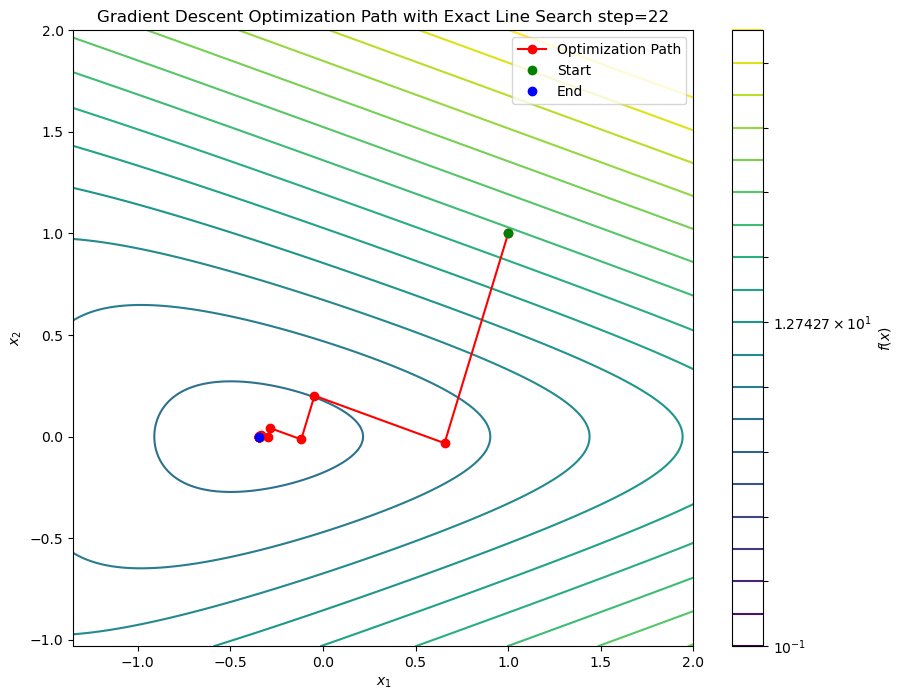

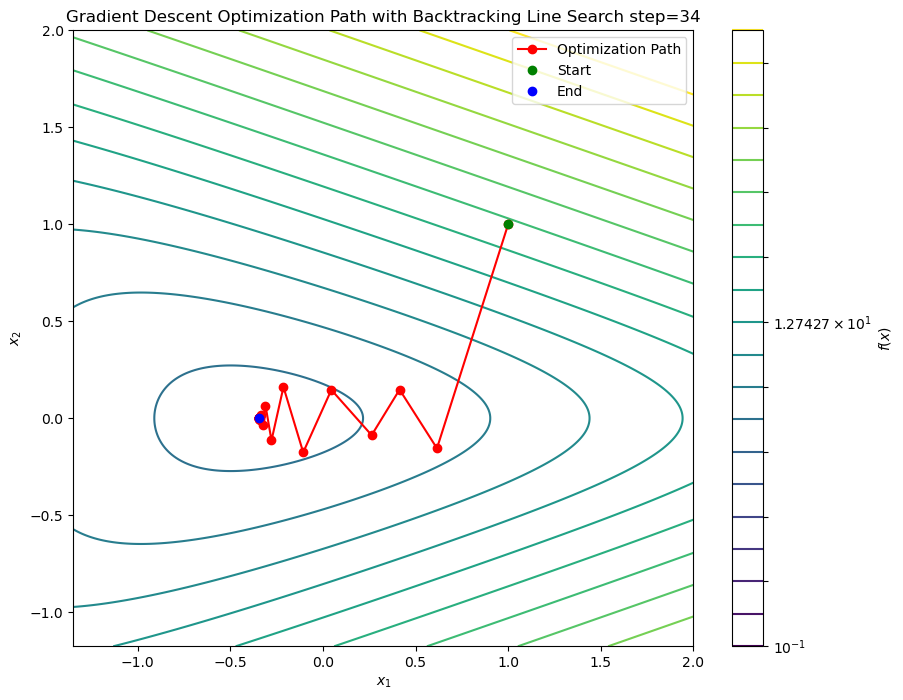

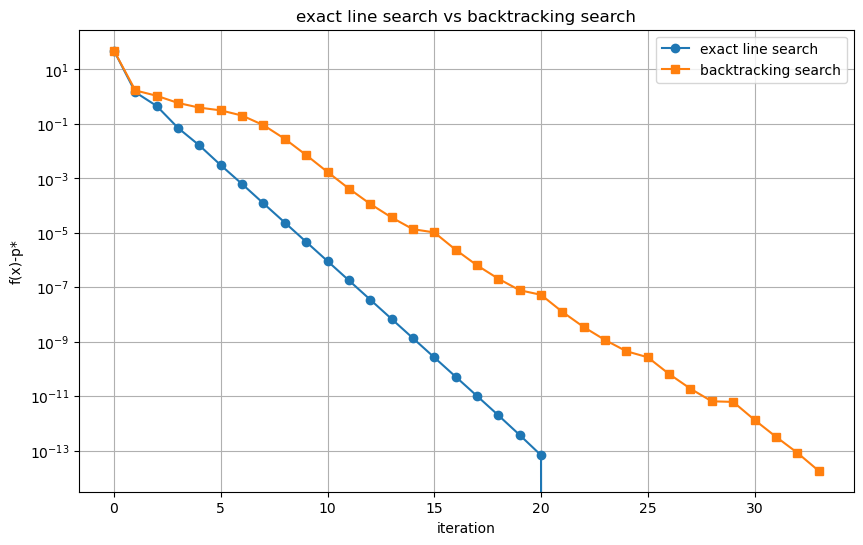

In [4]:
x_init = np.array([1.0, 1.0])

x1, history1 = gradient_descent_exact_line_search(x_init)
x2, history2 = gradient_descent_backtracking(x_init)

plot_optimization(history1, "Gradient Descent Optimization Path with Exact Line Search")
plot_optimization(history2, "Gradient Descent Optimization Path with Backtracking Line Search")

# 计算每个历史点的函数值
history1_values = [f(x) for x in history1]
history2_values = [f(x) for x in history2]

# 计算最小函数值
min_value = min(min(history1_values), min(history2_values))

# 计算与最小函数值的差
diff_history1 = np.array(history1_values) - min_value
diff_history2 = np.array(history2_values) - min_value

# 画图
plt.figure(figsize=(10, 6))
plt.plot(diff_history1, label='exact line search', marker='o')
plt.plot(diff_history2, label='backtracking search', marker='s')

plt.title('exact line search vs backtracking search')
plt.xlabel('iteration')
plt.ylabel('f(x)-p*')
plt.legend()
plt.grid()
plt.yscale('log')  # 如果差值范围差异较大，使用对数坐标
plt.show()

In [5]:
%matplotlib ipympl
alpha = np.linspace(0, 0.5, 10)
beta = np.linspace(1e-4, 0.99, 10)

x_init = np.array([2.0, 1.0])
X, Y = np.meshgrid(alpha, beta)  # 创建网格

# 初始化 Z 数据
Z = np.zeros(X.shape)

c=0
# 遍历网格计算函数值
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        c += 1
        alpha = X[i, j]
        beta = Y[i, j]
        x_opt, history = gradient_descent_backtracking(x_init,200, 1e-6, alpha, beta)
        Z[i, j] = len(history)
        print(f'{c}/{X.shape[0]*X.shape[1]}')

# plt.figure(figsize=(10, 8))
# plt.contour(X, Y, Z,  cmap='viridis')
# 绘制三维图像
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# 设置坐标轴标签
ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.set_zlabel('Steps')

plt.show()

Iteration 0: x = [-9.04837418e-05  0.00000000e+00], f(x) = 2.7144303921447324, t = 0.0001
Iteration 1: x = [-0.00018094  0.        ], f(x) = 2.7143485746176097, t = 0.0001
Iteration 2: x = [-0.00027138  0.        ], f(x) = 2.714266801501051, t = 0.0001
Iteration 3: x = [-0.00036179  0.        ], f(x) = 2.714185072769614, t = 0.0001
Iteration 4: x = [-0.00045217  0.        ], f(x) = 2.71410338839787, t = 0.0001
Iteration 5: x = [-0.00054253  0.        ], f(x) = 2.714021748360409, t = 0.0001
Iteration 6: x = [-0.00063287  0.        ], f(x) = 2.7139401526318347, t = 0.0001
Iteration 7: x = [-0.00072318  0.        ], f(x) = 2.7138586011867685, t = 0.0001
Iteration 8: x = [-0.00081347  0.        ], f(x) = 2.7137770939998465, t = 0.0001
Iteration 9: x = [-0.00090373  0.        ], f(x) = 2.713695631045722, t = 0.0001
Iteration 10: x = [-0.00099397  0.        ], f(x) = 2.7136142122990616, t = 0.0001
Iteration 11: x = [-0.00108419  0.        ], f(x) = 2.713532837734552, t = 0.0001
Iteration 12:

: 